In [15]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)

/home/icb/yuge.ji/miniconda3/envs/test_env3/lib/python3.10/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [2]:
import sys
sys.path.append("../scripts/")
import benchmarking

In [100]:
path = '../outputs/'
ranking_files = {
    'ablation':"ablation/task2_abs.csv",
    'de':"differential_expression/hlca_DE_cell_types.csv",
    'eg_abssum':"expected_gradients/task_2_absolute_sum_expected_grads.csv",
#     'eg_sum':"expected_gradients/task_2_sum_expected_grads.csv",
    'ig_abssum':"integrated_gradients/task_2_absolute_sum_integrated_grads.csv",
#     'ig_sum':"integrated_gradients/task_2_sum_integrated_grads.csv",
    'lime_abs':"lime/lime_absolute.csv",
    'lime':"lime/lime.csv",
    'mean':"baselines/task2_mean.csv",
    'random':"baselines/task2_random.csv",
}

ranking_dfs = {explainer: pd.read_csv(path + file_name, index_col=0) for explainer, file_name in ranking_files.items()}
ranking_dfs['de'] = -ranking_dfs['de']

We invert DE because p-values go in the wrong direction.

In [91]:
auc_scores = dict()

In [92]:
for explainer, df in ranking_dfs.items():
    print(explainer)
    auc_scores[explainer] = benchmarking.roc_auc_hlca(df)

ablation
de
eg_abssum
ig_abssum
lime_abs
lime
mean
random


In [93]:
auc_scores

{'ablation': 0.8941577620434161,
 'de': 0.906637166048448,
 'eg_abssum': 0.7537592802451452,
 'ig_abssum': 0.7505376175981571,
 'lime_abs': 0.5803599978000977,
 'lime': 0.5393283460974456,
 'mean': 0.9418018954812546,
 'random': 0.5394461758515804}

/tmp/ipykernel_123828/999192811.py:14: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False)


(0.0, 1.0)

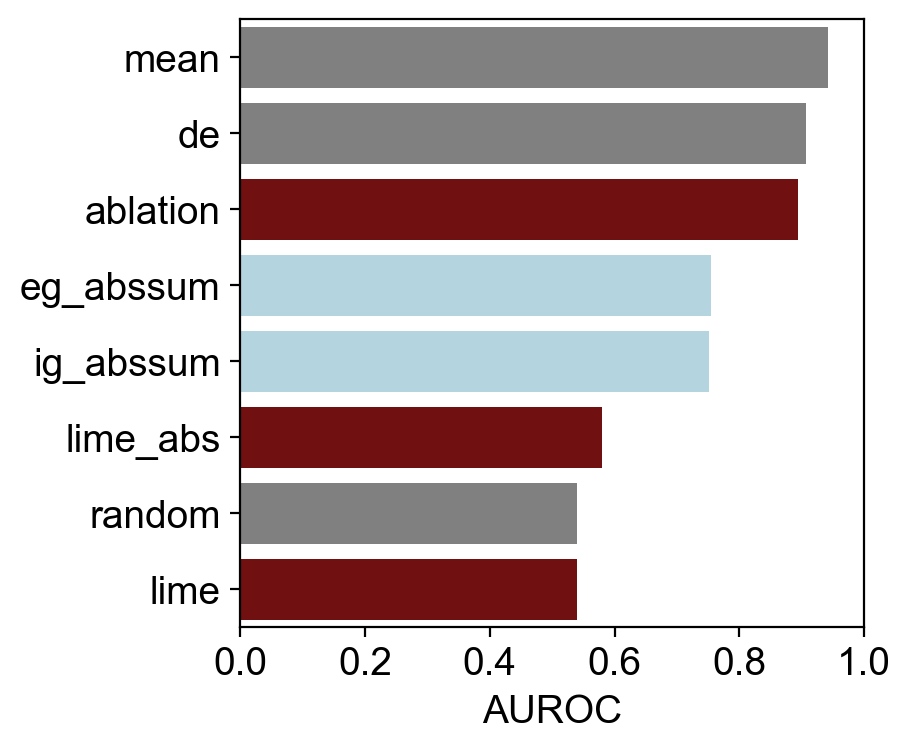

In [99]:
color_dict = {
    'eg_abssum': 'lightblue',  # gradient-based
    'ig_abssum': 'lightblue',
    'ablation': 'maroon',  # model agnostic
    'lime_abs': 'maroon',
    'lime': 'maroon',
    'de': 'grey',  # baselines
    'mean': 'grey',
    'random': 'grey'
}

df = pd.DataFrame.from_dict(auc_scores, orient='index').sort_values(by=0, ascending=False)
sns.barplot(df.T, orient='h', palette=color_dict)  # TODO: fix so that a palette appears
plt.grid(b=False)
plt.xlabel('AUROC')
plt.xlim(0, 1)

TODO: not sure about this result from ablation. It should perform better when we don't take the absolute values, as marker gene lists contain information about positive features and never negative features. However, we see that ablation performs considerably better when taking the absolute values of the attributions.

In [86]:
adata = sc.read("../datasets/hlca.h5ad")

In [97]:
pert_df = pd.DataFrame(index=list(adata.var_names), columns=ranking_dfs.keys())
for explainer, df in ranking_dfs.items():
    pert_df[explainer] = df['Secretory']

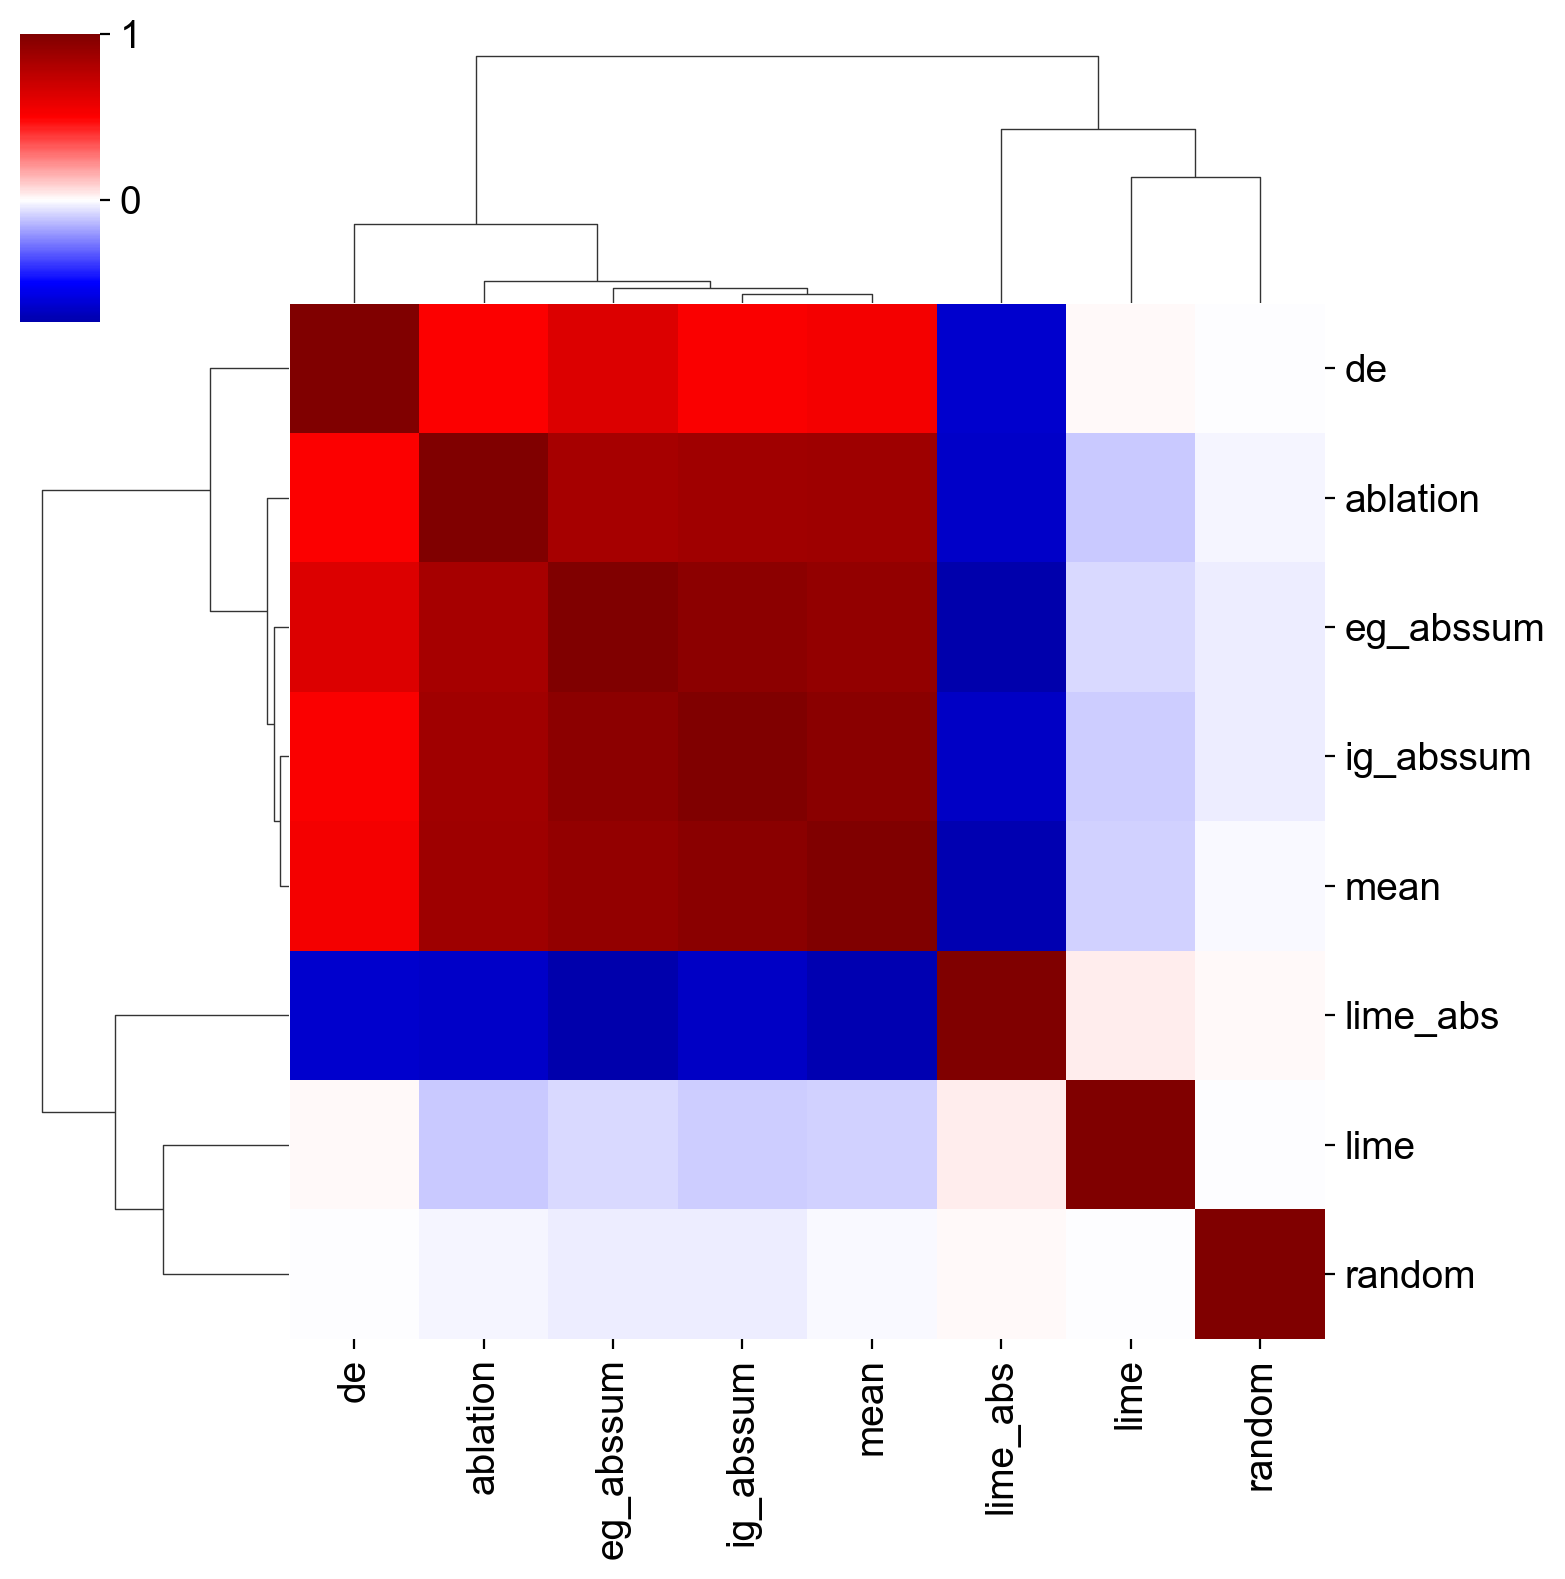

In [102]:
sns.clustermap(pert_df.corr(method='spearman'), cmap="seismic", center=0.00, figsize=(8, 8))